<a href="https://colab.research.google.com/github/letpires/bootcamp_alura/blob/main/Projeto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

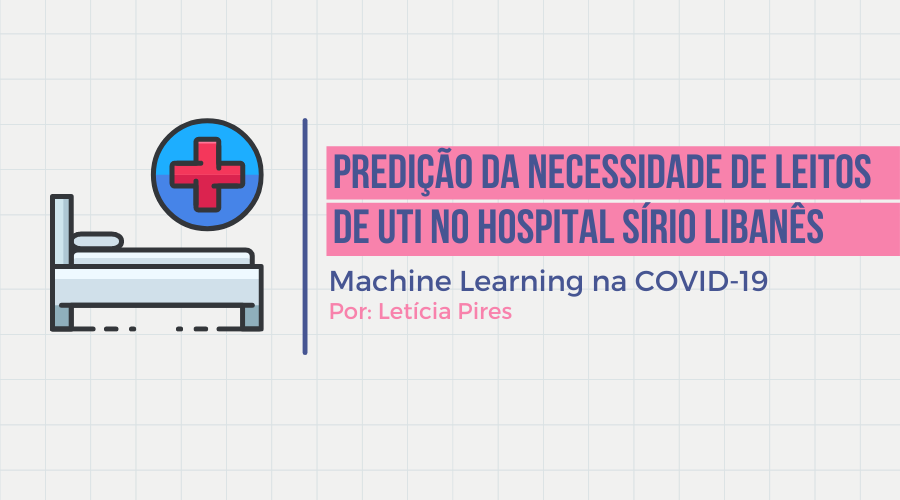

## PARTE 1

1) Remover os pacientes que chegaram nas 2 primeiras horas (window 0-2) e foram pra UTI

2) Preencher células vazias das variáveis contínuas

3) Manter na análise somente os pacimentos da janela 0-2

4) Criou-se uma coluna AGE_PERCENTIL para cada categoria, com valores binários

5) Foi isolado a janela 0-2, transformando em valor 1, pois estava como string

6) Criou-se uma coluna para cada gênero, em que o valor 1 significa a presenã da variável.

###**1.1 Importações** 

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import (plot_confusion_matrix, classification_report,
                             roc_auc_score, accuracy_score)
from sklearn.model_selection import (cross_validate, StratifiedKFold, 
                                     RepeatedStratifiedKFold, train_test_split)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix

from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import (ValidationCurve, LearningCurve) 
from yellowbrick.features.importances import FeatureImportances

import warnings
warnings.filterwarnings('ignore')


### 1.2 Funções

In [33]:
def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]


In [34]:
'''
Função que agrupa cada valor da coluna PATIENT_VISIT_IDENTIFIER e 
preenche os dados faltantes das variáveis contínuas através do método 
bfill e ffill
'''

def fill_table(data):
    features_continuas_colunas = data.iloc[:, 13:-2].columns
    features_continuas = data.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
    features_categoricas = data.iloc[:, :13]
    saida = data.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
    dados_finais.columns = data.columns
    return dados_finais

In [35]:
'''
Função que agrupa todos os grupos de dados de um paciente e atribui o valor 
ICU==1 na janela de até 2 horas
'''

def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

In [36]:
def roda_modelo(modelo, dados):
  
  x_columns = dados.columns
  y = dados["ICU"]
  x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)
  
  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

  modelo.fit(x_train, y_train)
  predicao = modelo.predict(x_test)
  prob_predict = modelo.predict_proba(x_test)

  auc = roc_auc_score(y_test, prob_predict[:,1])
  print(f"AUC {auc}")
  print("\nClassification Report")
  print(classification_report(y_test, predicao))

In [37]:
'''
Função que analisa a correlação entre as variáveis do banco de dados, cria uma
máscara para remover os dados espelhados e retorna os dados sem as variáveis 
com correlação maior que o valor de corte 0.95.
'''

def remove_corr_var(dados, valor_corte = 0.95):

  matriz_corr = dados.iloc[:,4:-2].corr().abs()
  matriz_superior = matriz_corr.where(np.triu(np.ones(matriz_corr.shape), k=1).astype(np.bool))
  excluir = [coluna for coluna in matriz_superior.columns if any(matriz_superior[coluna]> valor_corte)]
  
  return dados.drop(excluir, axis=1)


In [38]:
def roda_modelo_cv(modelo, dados, n_splits, n_repeats):
  
  np.random.seed(1231234)
  dados = dados.sample(frac=1).reset_index(drop=True)
  x_columns = dados.columns
  y = dados["ICU"]
  x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)

  cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
  resultados = cross_validate(modelo, x, y, cv=cv, scoring='roc_auc', return_train_score=True)

  auc_medio = np.mean(resultados['test_score'])
  auc_medio_treino = np.mean(resultados['train_score'])

  auc_std = np.std(resultados['test_score'])
  
  print(f"AUC {auc_medio} - {auc_medio_treino}")
  return auc_medio, auc_medio_treino

In [39]:
def roda_n_modelos(modelo, dados, n):
  
  x_columns = dados.columns
  y = dados["ICU"]
  x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)

  auc_lista = []

  # _ é utilizado como padrão, variável que não vamos utilizar os valores dados pela iteração
  for _ in range(n):
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

    modelo.fit(x_train, y_train)
    prob_predict = modelo.predict_proba(x_test)
    auc = roc_auc_score(y_test, prob_predict[:,1])
    auc_lista.append(auc)

  auc_medio = np.mean(auc_lista)
  auc_std = np.std(auc_lista)
  print(f"AUC médio =  {auc_medio}")
  print(f"Intervalo {auc_medio - 2* auc_std} - {auc_medio  + 2*auc_std}")

In [40]:
def resume_data(dataset  : pd.DataFrame):
  data_nan = dataset.isnull().any().any() #retorno os dados Not a Number das colunas
  dataset_types = list (set(dataset.dtypes.values)) #com o set realizo um "filtro" removendo dados repetidos
  print("--------------- INFORMAÇÕES GERAIS ---------------\n")
  #shape nos retorna uma tupla com dois valores, sendo um referente a linhas e o outro a coluna, respectivamente.
  print(f"Quantidade de instâncias: {dataset.shape[0]} (linhas)\nQuantidade de Atributos: {dataset.shape[1]} (colunas)\n")

  if data_nan:
    print(f"Possui dados NaN ? {data_nan}\nQuantidade de NaN totais: {dataset.isnull().sum().values.sum()}\n")
  else:
    print("Não há dados ausentes neste dataset\n")

  print(f"Tipos de  dados que temos :\n{dataset_types}\n")
  print("----------------------------------------------\n")

## **2.DADOS**

In [41]:
dados = pd.read_excel("https://github.com/letpires/bootcamp_alura/blob/main/modulo_final/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

## 3. PREPARANDO OS DADOS

In [42]:
dados_limpos = fill_table(dados)

#Remover pacientes em que a janela é de 0-2 horas e ICU=1(TRUE), porque significa que logo nas primeiras horas o paciente já foi pra UTI, então não precisamos desses dados.
a_remover = dados_limpos.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_limpos = dados_limpos.dropna()
dados_limpos

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.272727,-0.275362,0.736842,-0.339130,0.325153,0.114504,0.176471,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.27

In [43]:
dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
dados_limpos = pd.get_dummies(dados_limpos) 
dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU,AGE_PERCENTIL_10th,AGE_PERCENTIL_20th,AGE_PERCENTIL_30th,AGE_PERCENTIL_40th,AGE_PERCENTIL_50th,AGE_PERCENTIL_60th,AGE_PERCENTIL_70th,AGE_PERCENTIL_80th,AGE_PERCENTIL_90th,AGE_PERCENTIL_Above 90th,WINDOW_0-2
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1,0,0,0,0,0,1,0,0,0,0,1
2,10,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1,1,0,0,0,0,0,0,0,0,0,1
3,15,3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,-0.972789,...,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,0,0,0,1,0,0,0,0,0,0,1
4,20,4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,-0.935113,...,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0,1,0,0,0,0,0,0,0,0,0,1
5,25,5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073

In [44]:
dados_limpos.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU,AGE_PERCENTIL_10th,AGE_PERCENTIL_20th,AGE_PERCENTIL_30th,AGE_PERCENTIL_40th,AGE_PERCENTIL_50th,AGE_PERCENTIL_60th,AGE_PERCENTIL_70th,AGE_PERCENTIL_80th,AGE_PERCENTIL_90th,AGE_PERCENTIL_Above 90th,WINDOW_0-2
count,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.0,352.000000,352.000000,352.000000,352.000000,352.0,352.000000,352.000000,352.000000,352.000000,352.0,352.000000,352.000000,352.000000,352.000000,352.0,352.000000,352.000000,352.000000,352.000000,352.0,352.000000,352.000000,352.000000,...,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.0
mean,192.818182,0.457386,0.380682,0.105114,0.022727,0.090909,0.019886,0.127841,0.042614,0.193182,0.161932,0.832386,0.576854,0.576854,0.576854,0.576854,-1.0,-0.997843,-0.997843,-0.997843,-0.997843,-1.0,-0.958383,-0.958383,-0.958383,-0.958383,-1.0,-0.318320,-0.318320,-0.318320,-0.318320,-1.0,-0.320261,-0.320261,-0.320261,-0.320261,-1.0,-0.945688,-0.945688,-0.945688,...,-0.240459,-0.454741,0.107194,0.753962,0.108306,-0.087145,-0.143454,-0.390422,0.436876,0.896981,-0.313228,-0.500338,-0.383904,-0.504304,-0.077157,0.769737,-0.957856,-0.960855,-0.966863,-0.962066,-0.965233,-0.985365,-0.963091,-0.958921,-0.976421,-0.964390,-0.965725,-0.985390,0.463068,0.105114,0.119318,0.110795,0.107955,0.096591,0.085227,0.096591,0.102273,0.079545,0.096591,1.0
std,110.763735,0.498890,0.486246,0.307136,0.149245,0.287889,0.139809,0.334388,0.202272,0.395356,0.368913,0.374055,0.134550,0.134550,0.134550,0.134550,0.0,0.024345,0.024345,0.024345,0.024345,0.0,0.114628,0.114628,0.114628,0.114628,0.0,0.032392,0.032392,0.032392,0.032392,0.0,0.089648,0.089648,0.089648,0.089648,0.0,0.044260,0.044260,0.044260,...,0.285713,0.235012,0.275171,0.161405,0.235462,0.246015,0.252937,0.233023,0.165714,0.062834,0.186318,0.211692,0.225000,0.209839,0.229507,0.159424,0.111052,0.113712,0.095011,0.110411,0.086132,0.032640,0.106132,0.117561,0.059606,0.095115,0.084306,0.033025,0.499344,0.307136,0.324624,0.314325,0.310765,0.295820,0.279617,0.295820,0.303438,0.270973,0.295820,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.578947,-0.578947,-0.578947,-0.578947,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0000

In [45]:
resume_data(dados_limpos)

--------------- INFORMAÇÕES GERAIS ---------------

Quantidade de instâncias: 352 (linhas)
Quantidade de Atributos: 240 (colunas)

Não há dados ausentes neste dataset

Tipos de  dados que temos :
[dtype('float64'), dtype('int64'), dtype('uint8')]

----------------------------------------------



In [46]:
dados_limpos_sem_corr = remove_corr_var(dados_limpos)
dados_limpos_sem_corr

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_DIFF,FFA_MEDIAN,FFA_DIFF,GGT_MEDIAN,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_DIFF,HEMOGLOBIN_DIFF,INR_MEDIAN,...,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_DIFF,TGO_MEDIAN,TGO_DIFF,TGP_MEDIAN,TGP_DIFF,TTPA_MEDIAN,TTPA_DIFF,UREA_MEDIAN,UREA_DIFF,DIMER_MEDIAN,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,RESPIRATORY_RATE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,ICU,AGE_PERCENTIL_10th,AGE_PERCENTIL_20th,AGE_PERCENTIL_30th,AGE_PERCENTIL_40th,AGE_PERCENTIL_50th,AGE_PERCENTIL_60th,AGE_PERCENTIL_70th,AGE_PERCENTIL_80th,AGE_PERCENTIL_90th,AGE_PERCENTIL_Above 90th,WINDOW_0-2
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.183673,-1.0,-0.868365,-1.0,-0.742004,-1.0,-0.945093,-1.0,-0.891993,-1.0,0.090147,-1.0,-1.0,-0.932246,...,-1.0,-0.028571,-1.0,-0.997201,-1.0,-0.990854,-1.0,-0.825613,-1.0,-0.836145,-1.0,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,-0.500000,-0.247863,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1,0,0,0,0,0,1,0,0,0,0,1
2,10,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.912243,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.780261,-1.0,0.144654,-1.0,-1.0,-0.959849,...,-1.0,0.085714,-1.0,-0.995428,-1.0,-0.986662,-1.0,-0.846633,-1.0,-0.836145,-1.0,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.714286,-0.435897,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,1,1,0,0,0,0,0,0,0,0,0,1
3,15,3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.972789,-1.0,-1.0,-1.0,0.326531,-1.0,-0.968861,-1.0,-0.194030,-1.0,-0.316589,-1.0,-0.891993,-1.0,-0.203354,-1.0,-1.0,-0.959849,...,-1.0,0.200000,-1.0,-0.989549,-1.0,-0.956555,-1.0,-0.846633,-1.0,-0.937349,-1.0,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,-0.357143,-0.299145,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,0,0,0,1,0,0,0,0,0,0,1
4,20,4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.935113,-1.0,-1.0,-1.0,0.357143,-1.0,-0.913659,-1.0,-0.829424,-1.0,-0.938084,-1.0,-0.851024,-1.0,0.358491,-1.0,-1.0,-0.959849,...,-1.0,0.142857,-1.0,-0.998507,-1.0,-0.991235,-1.0,-0.846633,-1.0,-0.903614,-1.0,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,-0.571429,-0.076923,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0,1,0,0,0,0,0,0,0,0,0,1
5,25,5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.891012,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.891993,-1.0,0.291405,-1.0,-1.0,-0.959849,...,-1.0,0.085714,-1.0,-0.997947,-1.0,-0.988948,-1.0,-0.846633,-1.0,-0.884337,-1.0,-1.000000,-1.0,-0.037037,-0.538462,-0.537736,-0.525424,-0.196429,0.815789,-0.428571,-0.247863,-0.826087,-0.754601,-0.984733,-1.000000,-0.976190,-0.979798,-0.986481,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...

In [47]:
resume_data(dados_limpos_sem_corr)

--------------- INFORMAÇÕES GERAIS ---------------

Quantidade de instâncias: 352 (linhas)
Quantidade de Atributos: 109 (colunas)

Não há dados ausentes neste dataset

Tipos de  dados que temos :
[dtype('float64'), dtype('int64'), dtype('uint8')]

----------------------------------------------



## 4. EXECUTANDO MODELOS DE MACHINE LEARNING

### Dados a serem treinados:
 - dados_limpos: possui todas as colunas
 - dados_limpos_sem_corr: dados com colunas sem alta correlação.

No nosso caso, utilizarei os seguintes modelos:



*   DummyClassifier
*   LogisticRegression
*   DecisionTreeClassifier
*   RandomForestClassifier

In [48]:
def criar_treino_teste(dataset):
  np.random.seed(727356)
  x_columns = dataset.columns
  y = dataset["ICU"]
  x = dataset[x_columns].drop(["ICU","PATIENT_VISIT_IDENTIFIER"], axis=1)
  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

  return  x_train, x_test, y_train, y_test



In [49]:
def roda_modelo(modelo, dados):
  np.random.seed(154145)
  x_columns = dados.columns
  y = dados["ICU"]
  x = dados[x_columns].drop(["ICU"], axis=1)

  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

  
  modelo.fit(x_train, y_train)

  predicao = modelo.predict(x_test)
  prob_predic = modelo.predict_proba(x_test)
  
  auc = roc_auc_score(y_test,prob_predic[:,1])
  print(f"AUC: {auc}")
  print("\nClassification Report")
  print(classification_report(y_test,predicao))

In [50]:
def acuracia (dados, modelo):
  x_train,x_test,y_train,y_test = criar_treino_teste(dados)
  modelo.fit(x_train,y_train)
  predicao_dados = modelo.predict(x_test)
  #separa-se os dados aqui para evitar erros externos.
  print(f"A acurácia do Modelo Logístico para dados_limpos é de : {(accuracy_score(y_test, predicao_dados))*100 :.2f} %")

In [51]:
def plote_confusion_matrix(dados, modelo):
  x_train,x_test,y_train,y_test = criar_treino_teste(dados)
  modelo.fit(x_train,y_train)
  predicao_dados = modelo.predict(x_test)


  fig, ax = plt.subplots(figsize=(7,7))

  figure = plot_confusion_matrix(modelo, x_test, y_test, ax=ax, cmap="PuBu", display_labels=['Não deve \n internar','Deve \n internar'])

  ax.set_title("Confusion matrix\n(Normalized values)", fontsize=16, fontweight="bold")
  ax.set_xlabel("Predicted label", fontsize=18)
  ax.set_ylabel("True label", fontsize=18)



In [52]:
def plotar_roc_auc(modelo,dados,name_dataset):
  np.random.seed(165488)
  
 
  x_train, x_test, y_train, y_test = criar_treino_teste(dados)
  #Separamos os dados de treino e teste

  #treinamos
  modelo.fit(x_train, y_train)
  #predizemos 
  predicao = modelo.predict(x_test)
  #plotamos a figura na qual ROCAUC irá realizar os calculos, pedindo apenas que
  #passemos o modelo
  fig, aux = plt.subplots(figsize=(9,9))
  roc_viz = ROCAUC(modelo)
  #realizamos também os calculos de pontuação que são apresentados na legenda do gráfico
  roc_viz.score(x_test,y_test)
  plt.legend()
  plt.title(f"Curva ROC para {name_dataset} - MODELO {modelo.__class__.__name__}")
  plt.show()

In [53]:
def validation_curve(modelo,dados,n_range_max, param):
  np.random.seed(165488)
  
 
  x_train, x_test, y_train, y_test = criar_treino_teste(dados)
  #Separamos os dados de treino e teste

  
  fig, aux = plt.subplots(figsize=(9,9))
  vc_viz = ValidationCurve(modelo, param_name=param, param_range=np.arange(11, n_range_max), cv=10, n_jobs=-1)

  vc_viz.fit(x_train,y_train)
  vc_viz.poof()

In [54]:
def curve_of_learning(modelo, dados):
  np.random.seed(165488)
  
 
  x_train, x_test, y_train, y_test = criar_treino_teste(dados)

  fig,ax = plt.subplots(figsize=(12,6))
  lc3_viz=LearningCurve(modelo, cv=10)

  lc3_viz.fit(x_train,y_train)
  lc3_viz.poof()


In [55]:
from yellowbrick.classifier import ClassBalance

def balanceamento_classes(dados):
  np.random.seed(165488)
  
 
  x_train, x_test, y_train, y_test = criar_treino_teste(dados)

  fig,ax = plt.subplots(figsize=(12,6))
  cb_viz=ClassBalance(labels=["Internado", "Não internado"])

  cb_viz.fit(y_test)
  cb_viz.poof()

In [57]:
def plotar_FeatureImportances (dados, modelo):
  x_train,x_test,y_train,y_test = criar_treino_teste(dados)
  modelo.fit(x_train,y_train)
  predicao_dados = modelo.predict(x_test)
  #depois de separado os dados de treino e teste e depois dos treinamentos e predições
  #criamos um grafico
  fig,ax = plt.subplots(figsize=(15,35))
  #passamos o modelo que irá ser usados para detectar as colunas "mais importantes"
  fi_viz = FeatureImportances(modelo)
  #realizamos um teste com as configurações instanciadas na variável anterior
  fi_viz.fit(x_test,y_test)
  #mostramos
  fi_viz.poof()

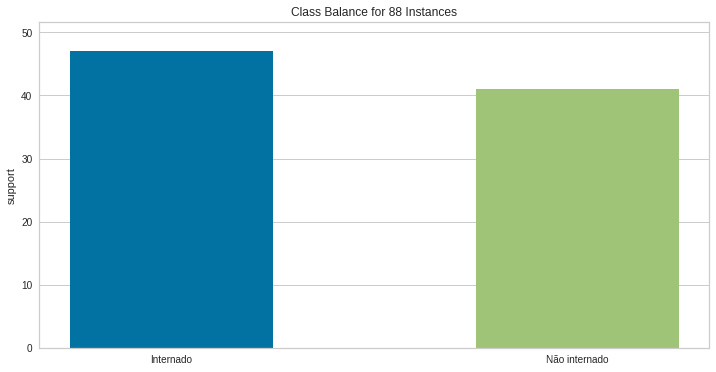

In [58]:
balanceamento_classes(dados_limpos)

In [59]:
modelo_logistic_regression_dados_limpos = LogisticRegression(max_iter=1000000)

In [60]:
acuracia(dados_limpos, modelo_logistic_regression_dados_limpos)

A acurácia do Modelo Logístico para dados_limpos é de : 70.45 %


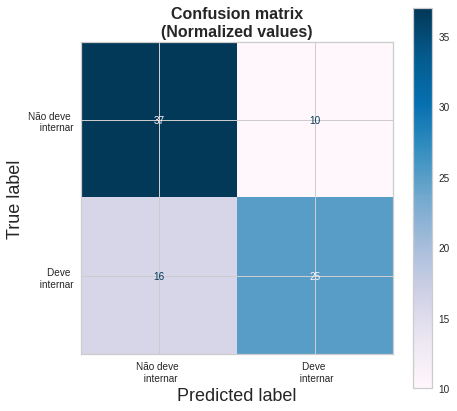

In [61]:
plote_confusion_matrix(dados_limpos, modelo_logistic_regression_dados_limpos )

In [62]:
roda_modelo(modelo_logistic_regression_dados_limpos, dados_limpos )

AUC: 0.8240788790866632

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.77      0.76        47
           1       0.72      0.71      0.72        41

    accuracy                           0.74        88
   macro avg       0.74      0.74      0.74        88
weighted avg       0.74      0.74      0.74        88



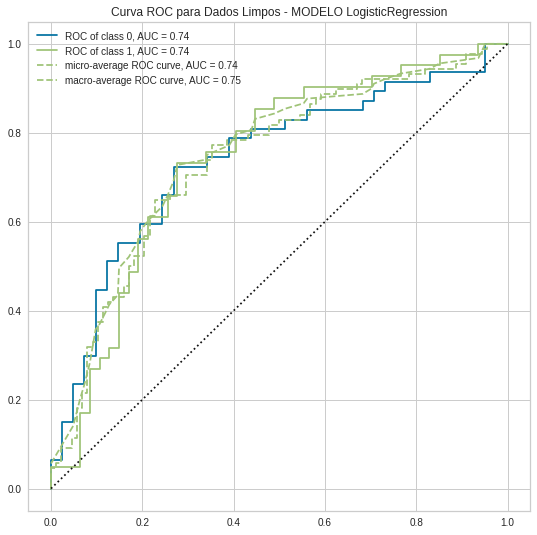

In [63]:
plotar_roc_auc(modelo_logistic_regression_dados_limpos, dados_limpos, "Dados Limpos")

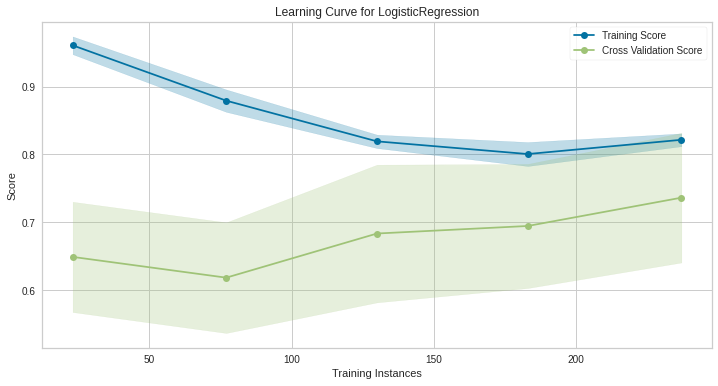

In [64]:
curve_of_learning(modelo_logistic_regression_dados_limpos, dados_limpos)

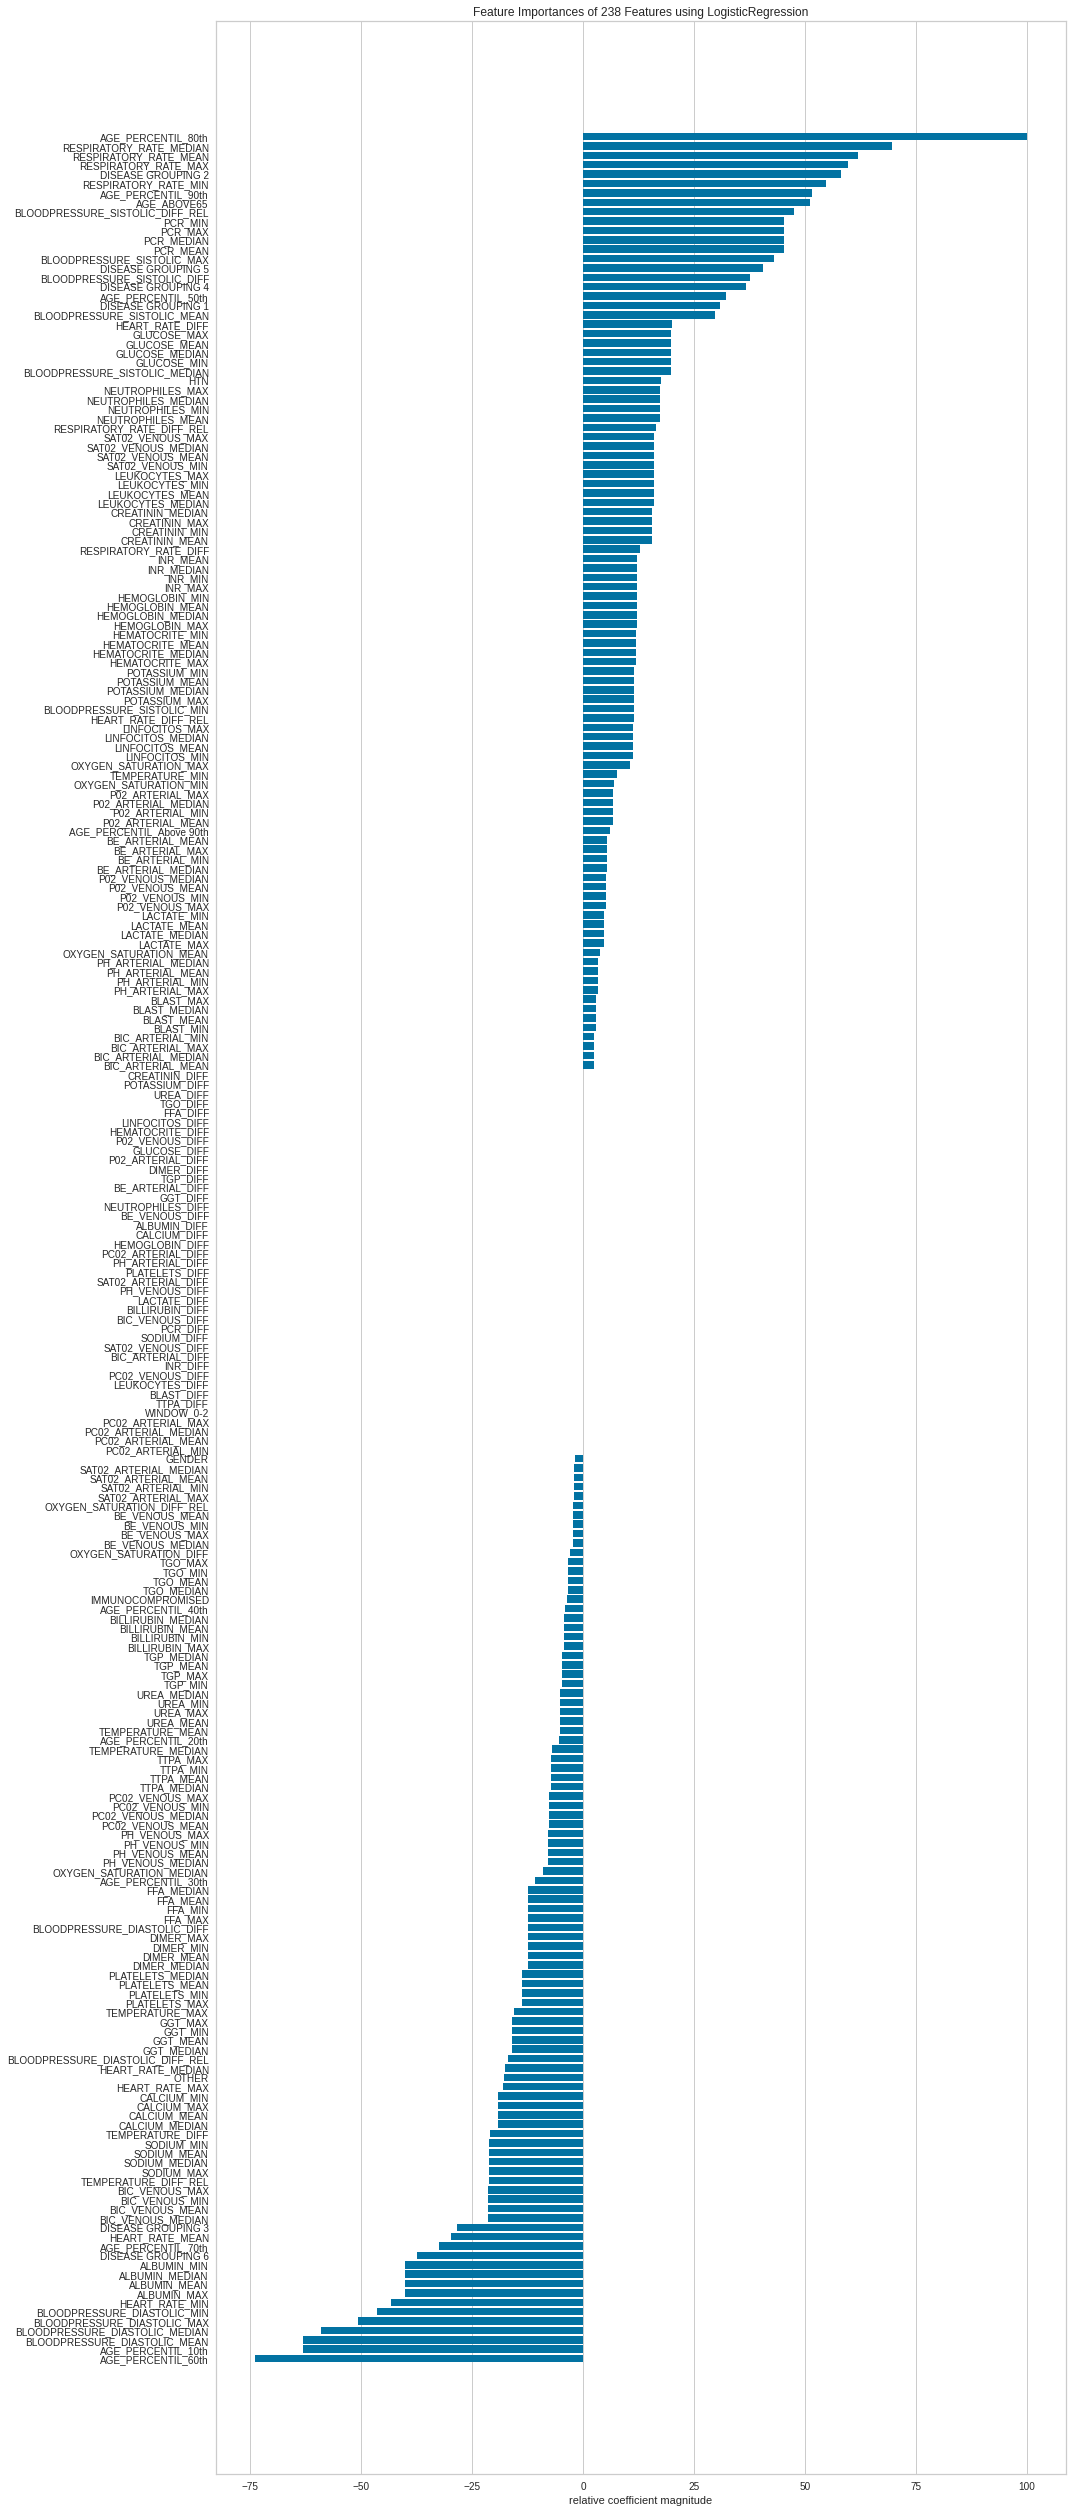

In [72]:
plotar_FeatureImportances(dados_limpos, modelo_logistic_regression_dados_limpos)